# Import modules needed

In [1]:
import numpy as np
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from tqdm import tqdm

# Functions

These functions below deal with the Elmegreen fractal generating algorithm itself.

The funtion `coord_func` is equivalent to the equation:

$$
x_n = x_{n-1} + \frac{|2\mathcal{L} - 1 |}{\mathcal{S}^g}
$$

where $\mathcal L$ is a linear random deviate on the interval $[0,1]$, $\mathcal S$ is the scaling parameter as described by Elmegreen (1997), and $g$ is the generation. This function generates $\mathcal F$ values of $x_n$, described as the number of children.

The function `fractal_point_gen` defines the logic needed to generate the points which constitute the fractal field. The `integer` parameter let's the function decide whether we want an integer $\mathcal S$ (`integer='S'`) or an integer $\mathcal F$ (`integer ='F'`). Subsequently, the function has the optional parameters `S` and `F`, one of which must be defined depending on the choice of `integer`. The function also takes as parameters; the number of generations $\mathcal G$, the fractal dimension, $D$, and the Euclidean dimension, $E$.

If we want an integer $\mathcal S$ the function calculates, $\mathcal{F}$, $\mathcal{F}_{\rm{ST}}$, $\mathcal{F}_{\rm{LO}}$, $\mathcal{F}_{\rm{HI}}$, and $\Delta\mathcal{F}$. It then sets up the appropriate values of $\mathcal{F}$ and $\mathcal G$ with which to pass to `coord_func`. The first $\mathcal F$ value is equal to $\mathcal{F}_{\rm{ST}}$, the rest are set as follows:

\begin{eqnarray}
{\cal F}_{_{\rm{LO}}}\,,&{\rm{if}}&{\cal L}>\Delta{\cal F}\,,\\
{\cal F}_{_{\rm{HI}}}\,,&{\rm{if}}&{\cal L}<\Delta{\cal F}\,.
\end{eqnarray}

A set of points are generated $E$ times to get an $E$-dimensional set of coordinates.

`fractal_point_gen` also has the option to pass these coordinates to the `star_culling` function before returning them.

The function `star_culling` takes a set of coordinates and culls points randomly to a desired number.

The function `fractal_field_gen` returns a histogram based on `fractal_point_gen`.

In [2]:
def coord_func(x,S,g,F):
    L = np.random.random(F)
    return x + 2*(L-0.5)/S**g

def fractal_point_gen(integer,G,D,E=2,S=None,F=None,N_points=None):
    if integer == 'S':
        F=S**D
        F_st = int(F+0.5)
        F_lo = int(F)
        F_hi = F_lo+1
        F_change = F - F_lo
        L = np.random.random(G-1)
        F_array = np.concatenate((np.array([F_st]),np.where(L>F_change,F_lo,F_hi)),axis=None)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g,f in np.array([G_array,F_array]).T:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,f)]
            points.append(x)
    if integer == 'F':
        S=F**(1/D)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g in G_array:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,F)]
            points.append(x)
    if N_points:
        points = star_culling(points,N_points)
    return points

def star_culling(points, N_points):
    while len(points[0])>N_points:
            n=1+int(np.random.random()*(len(points[0])-1))
            del points[0][n-1]
            del points[1][n-1]
    return points

def fractal_field_gen(integer,G,D,E,S=None,F=None,N_pix=None,seed=None):
    if seed != None:
        np.random.seed(int(seed))  
    if N_pix==None:
        N_pix = S**G
    fractal_points = fractal_point_gen(integer,G,D,E,S,F)
    fractal_field = np.histogramdd(fractal_points, bins=int(N_pix))[0]
    return fractal_field

The functions below deal with calculating the cumulative probability distribution for the separations of a set of points.

Given a set of $\cal I$ stars, where each star has position $\mathbf r_i \equiv (x_i,y_i)$, the cumulative probability probability distribution is,

$$P(s) \simeq \frac{2\cal N(<s)}{\cal I (\cal I -1)}$$

where $\cal N(<s)$ is the number of separations less than $s$. 

This requires us to compute all inter-star separations,

$$s_{ij} = \big|\mathbf r_i - \mathbf r_j\big|$$

making sure we only count each separation once.

The function `ordered_separations` computes all the unique separations for a set of points.

The function `cum_dist_seps` takes a set of points, its separations, and the value $s$ and computes the cumulative probability that a separation is less than $s$.

The function `two_pt_corr` takes the set of points, the cumulative probability, $P(s)$, and the value $s$ and computes the two-point correlation function according to,

$$
\xi_2(s) \simeq \frac{dP_2/ds}{2\pi s \tilde N}-1
$$

where $\tilde N = \cal I/\cal A$ with $\cal A$ being the area of the convex hull of the set of points

In [3]:
from scipy.spatial import ConvexHull

def ordered_separations(points):
    coords = [(point[0], point[1]) for point in np.array(points).T]
    distance_matrix = distance.cdist(coords, coords, 'euclidean')
    separations = np.unique(distance_matrix[distance_matrix != 0])
    return separations

def cum_dist_seps(coords,separations,s):
    N_s = np.sum(np.where(separations<s,1,0))
    I=len(coords)
    P_s = 2*N_s/(I*(I-1))
    return P_s

def two_pt_corr(coords, P_s, s):
    coords=np.array(coords).T
    I = len(coords)
    A = ConvexHull(coords).volume
    N_bar = I/A
    dpds = np.gradient(P_s,s[1]-s[0])
    return dpds/(2*np.pi*s*N_bar) - 1

# Implementation

In [4]:
N_fields = 10
S_LIST=[2,3]*N_fields
D = 2.3
G_LIST = [6,4]*N_fields
E=2

params = np.array([S_LIST,G_LIST]).T
params[:10]

array([[2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4]])

In [5]:
star_fields_integer_S = [fractal_point_gen('S',g,D,E,S=s) for s,g in params]
sizes_fields_integer_S = np.array([len(field[0]) for field in star_fields_integer_S])
min_stars = np.min(sizes_fields_integer_S)
culled_star_fields_integer_S = [star_culling(field, min_stars) for field in star_fields_integer_S]
len(culled_star_fields_integer_S)

20

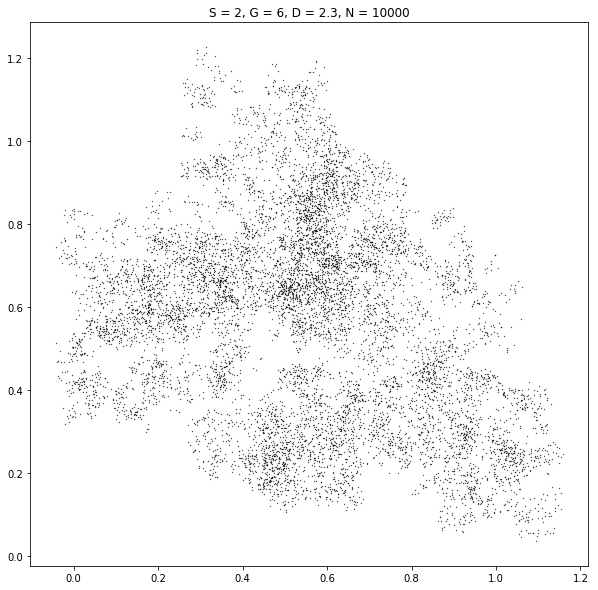

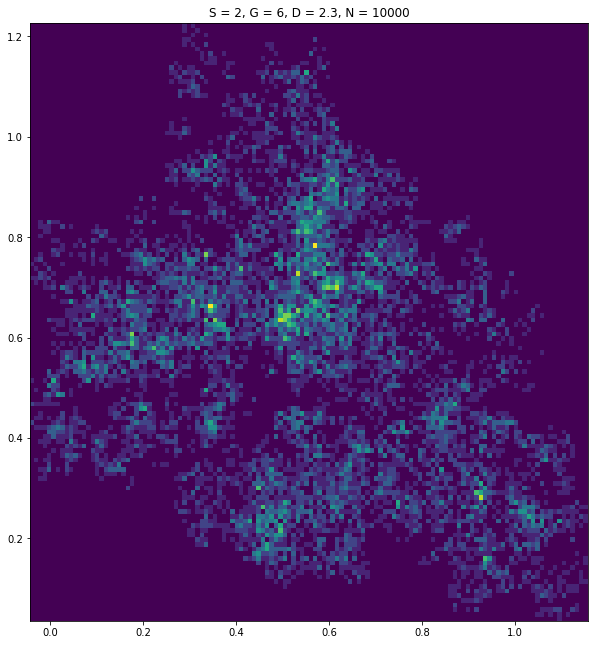

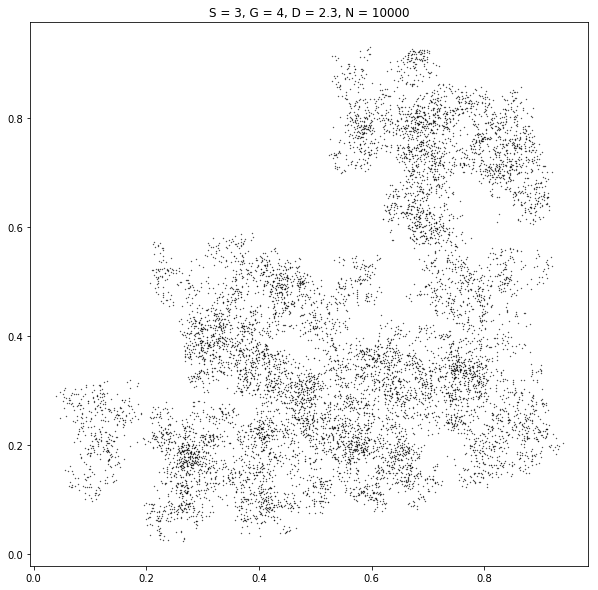

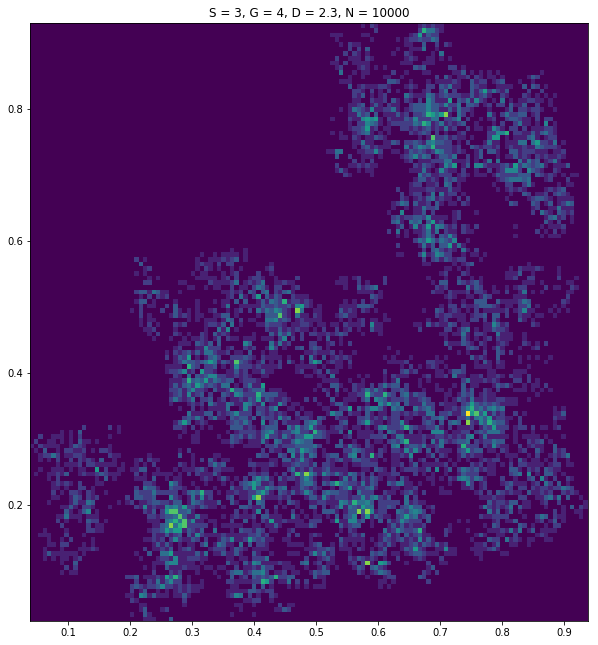

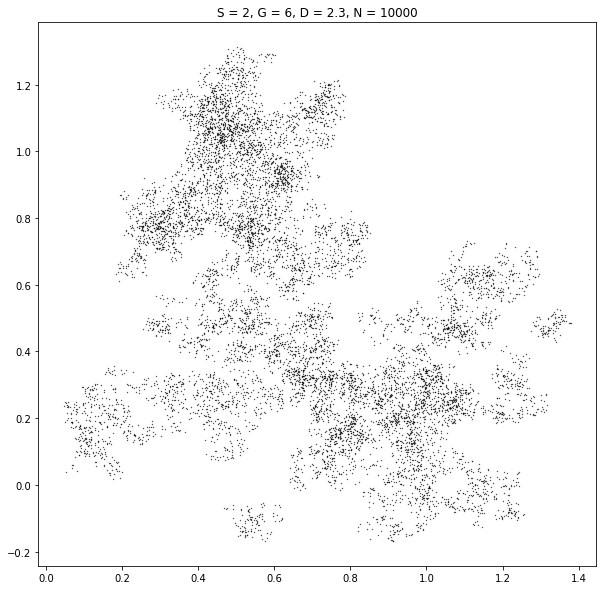

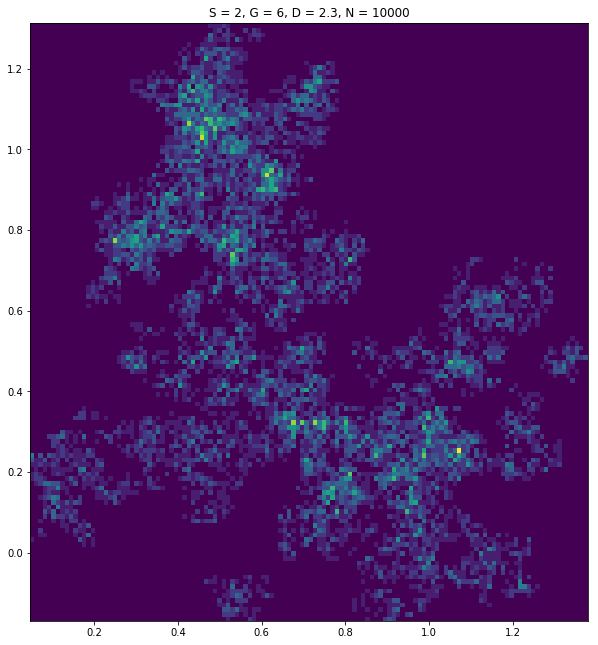

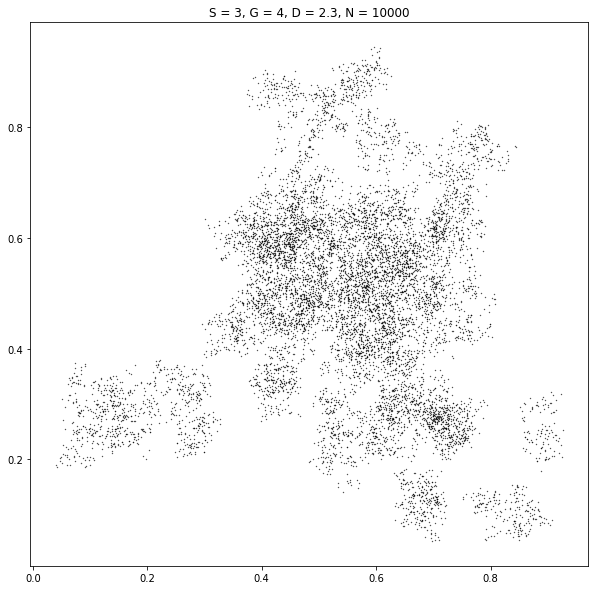

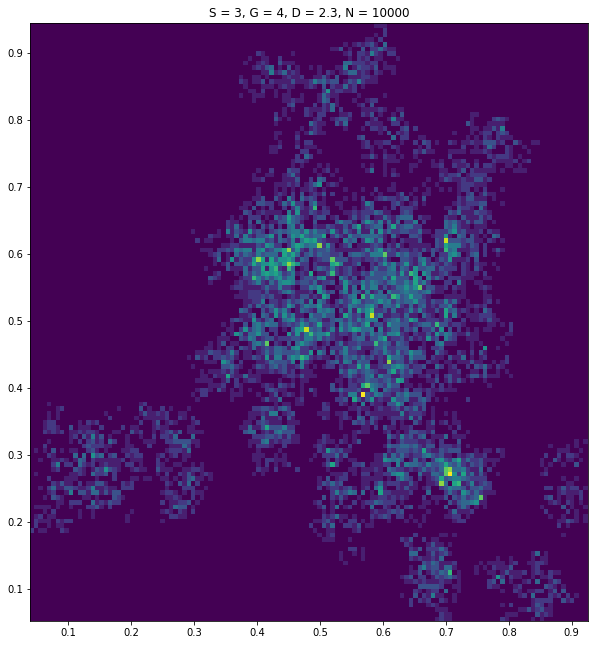

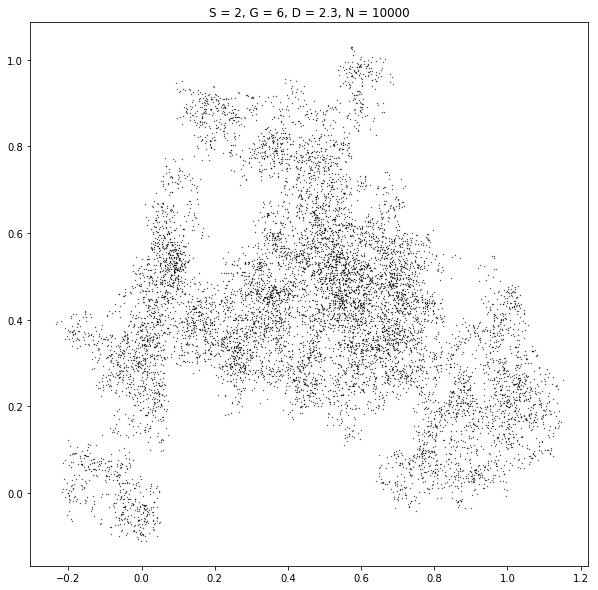

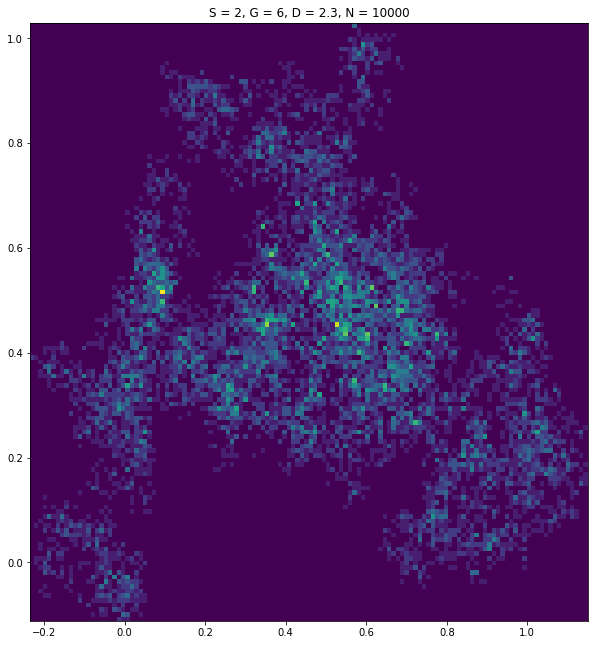

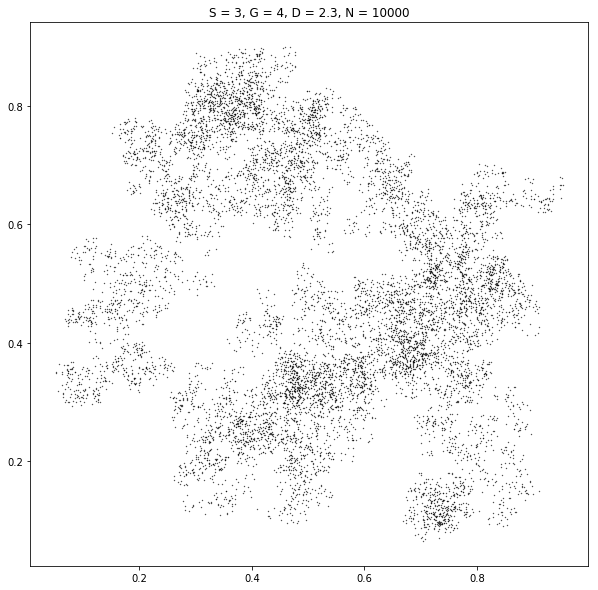

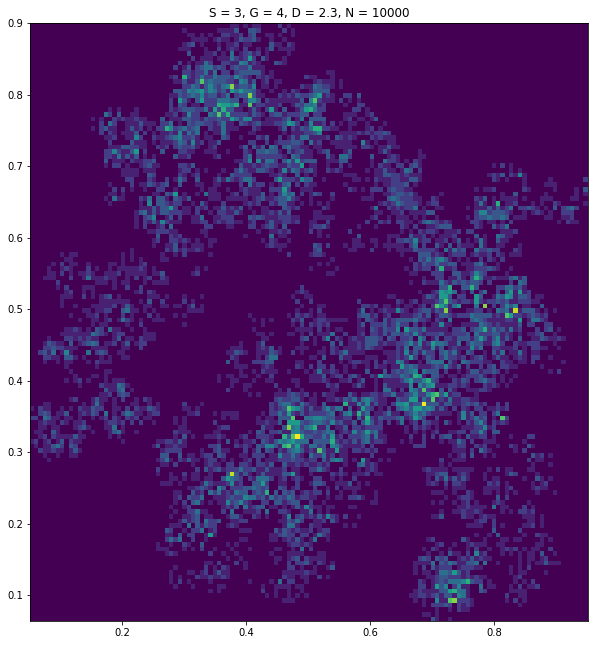

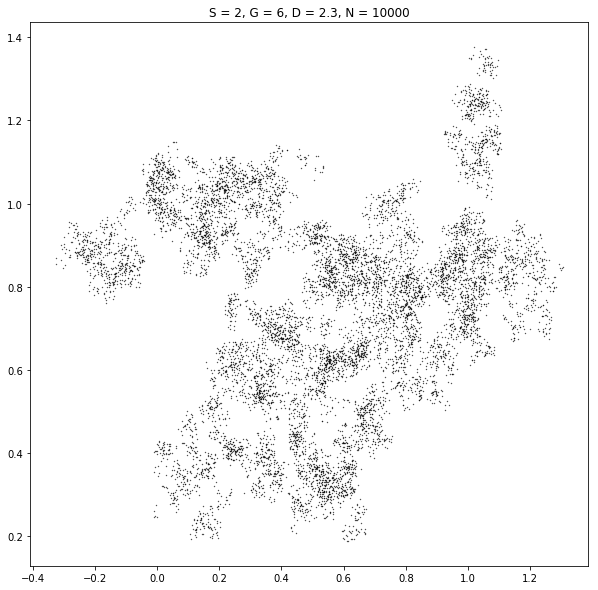

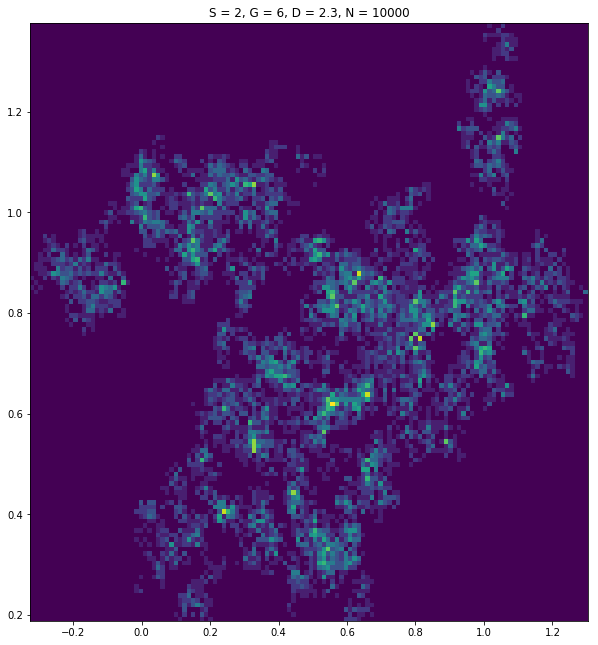

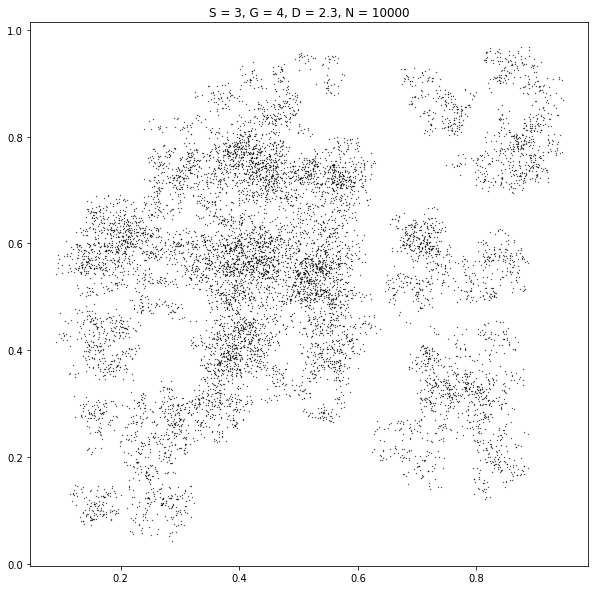

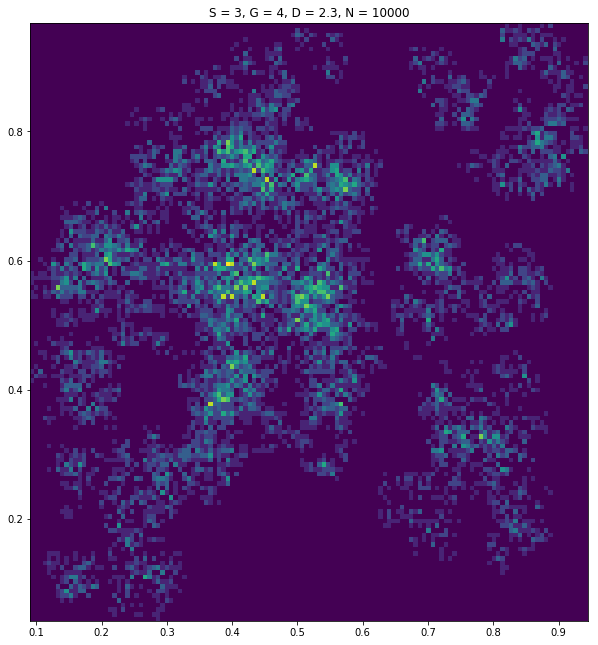

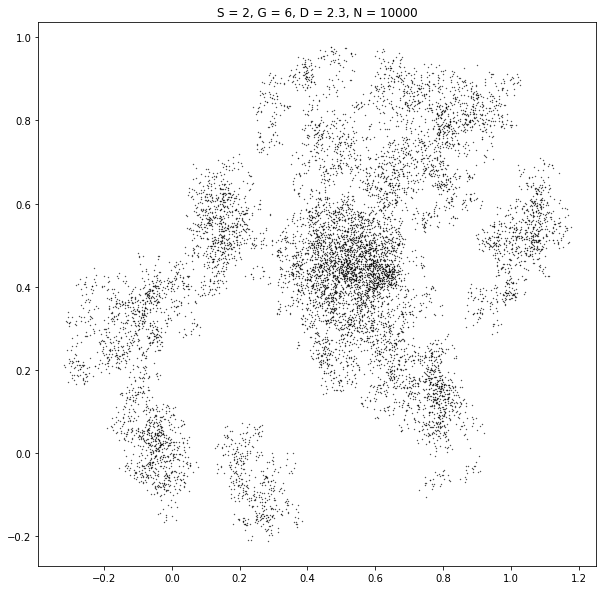

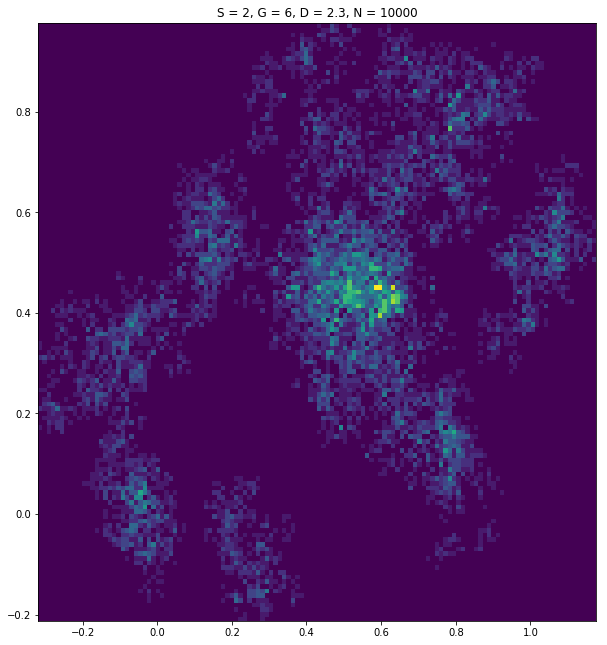

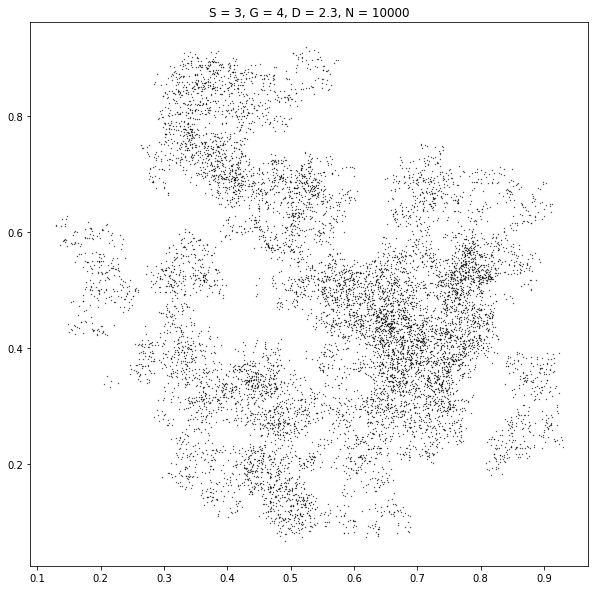

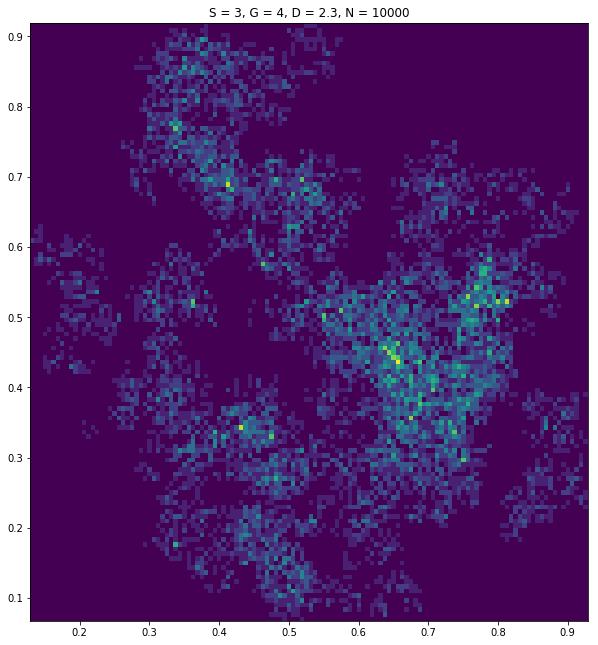

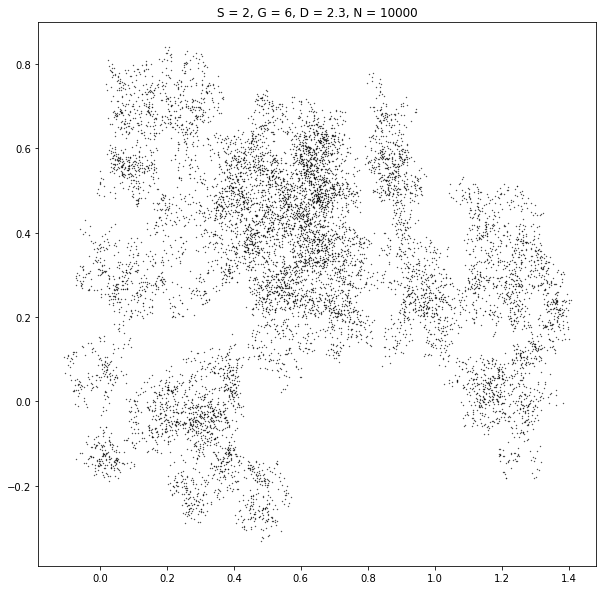

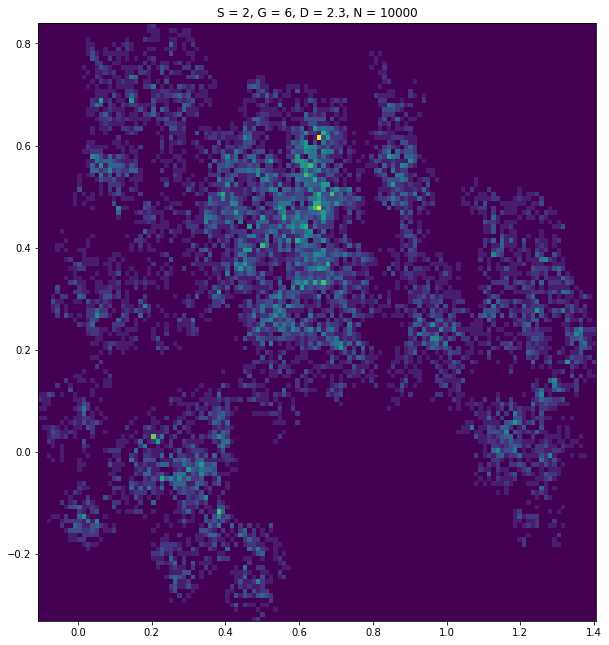

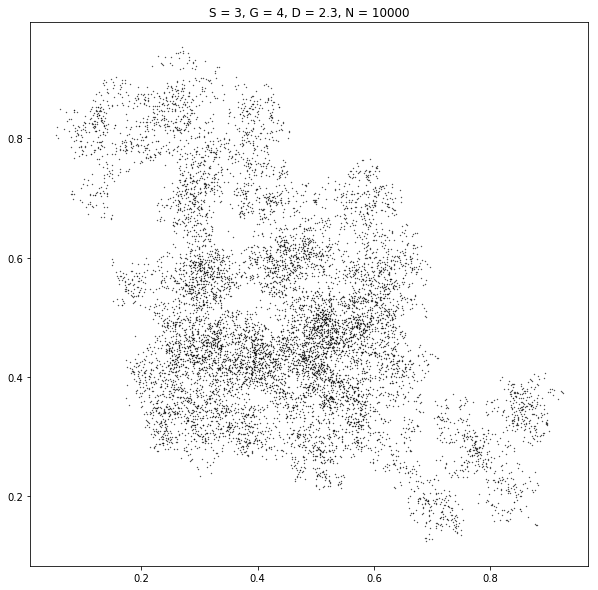

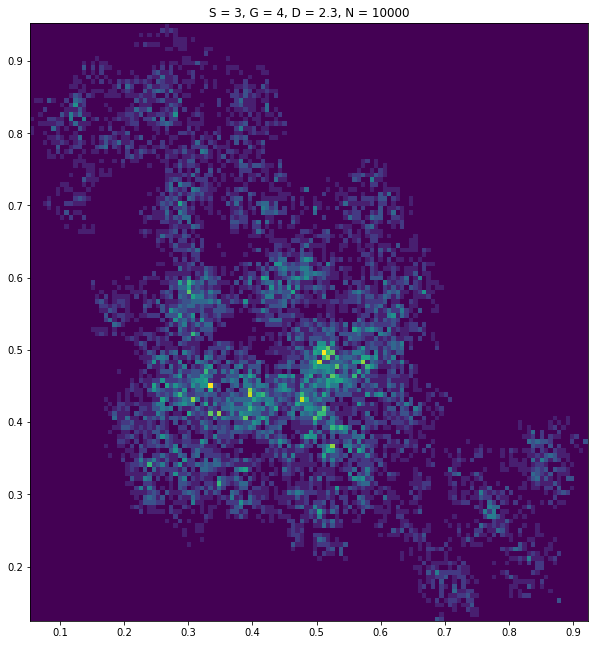

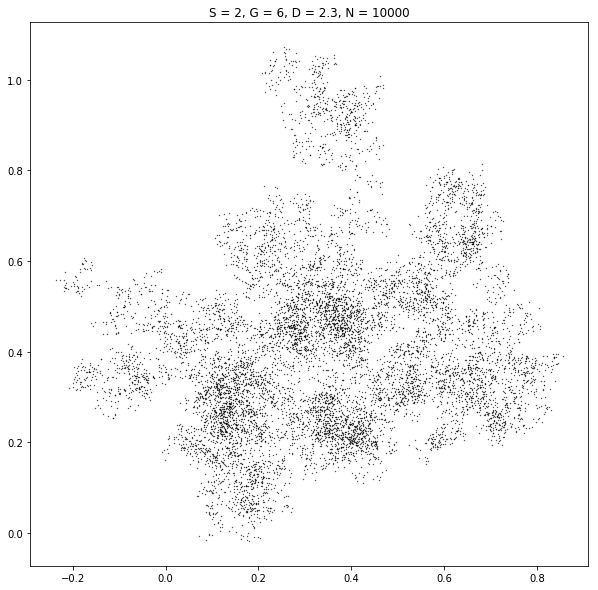

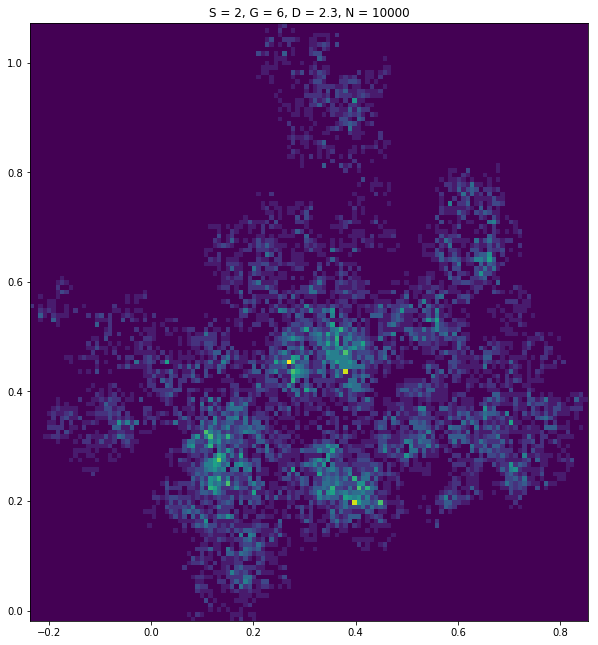

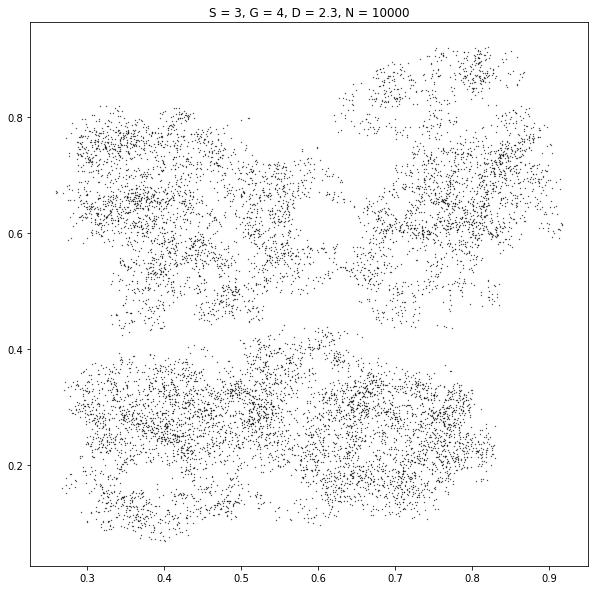

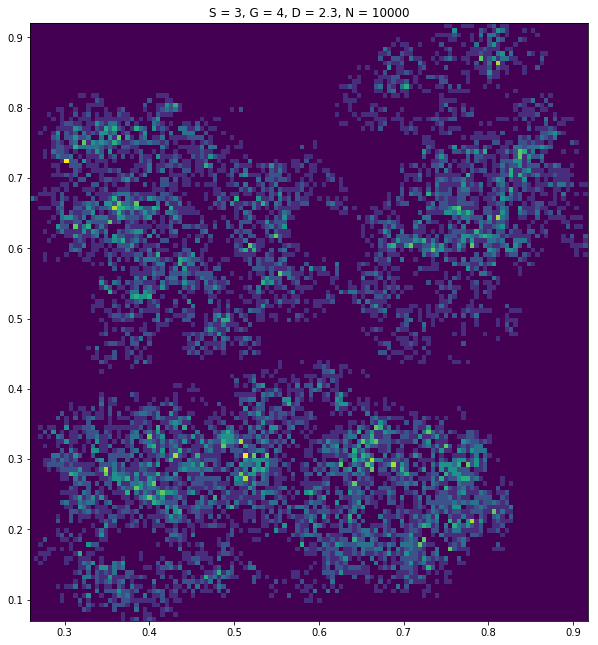

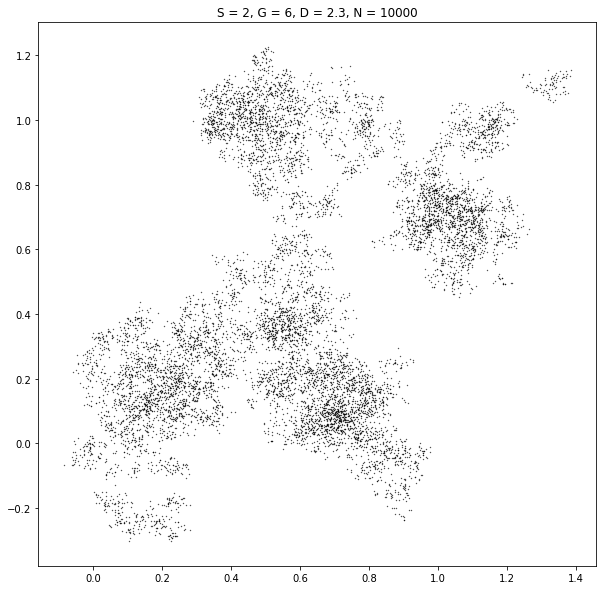

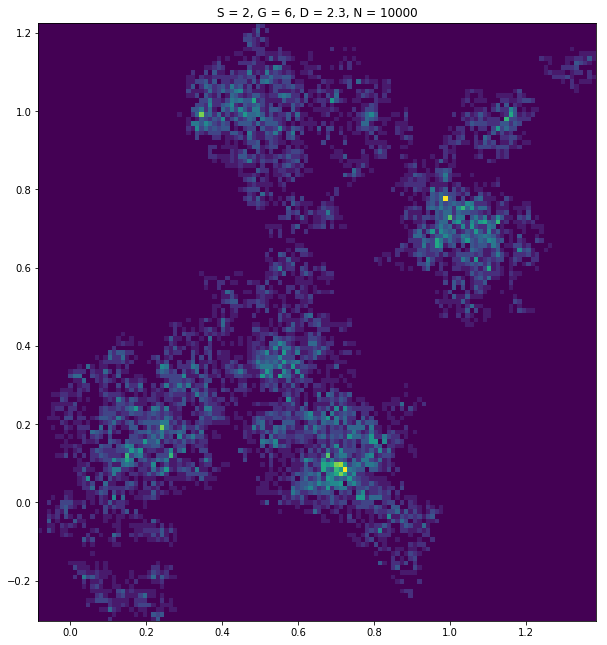

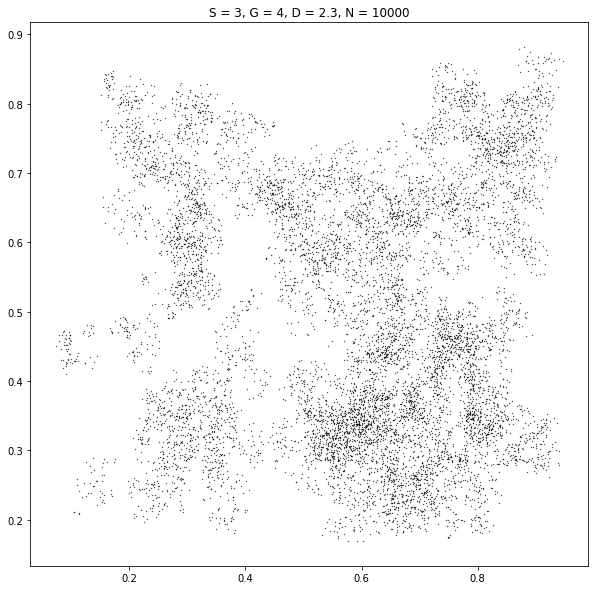

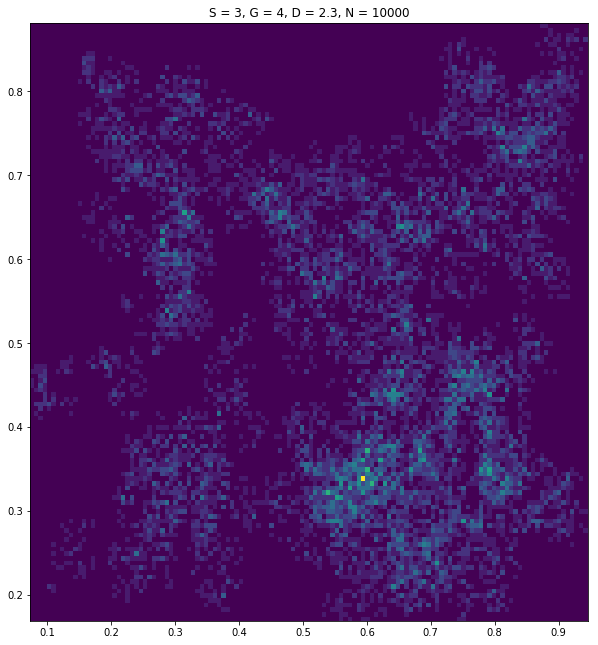

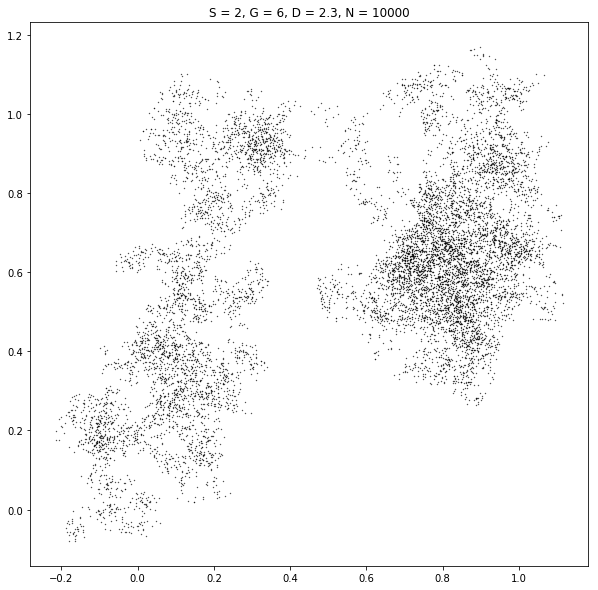

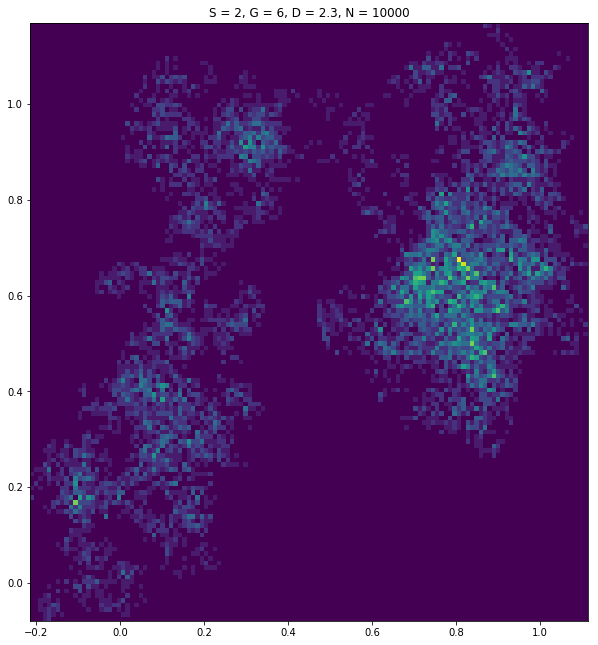

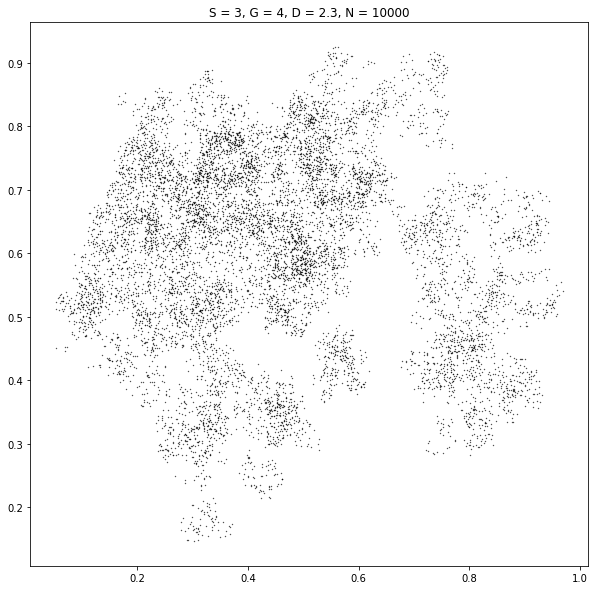

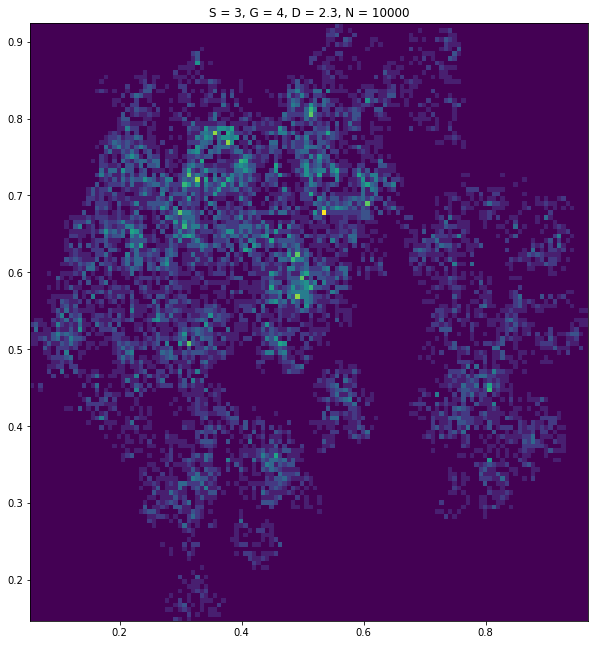

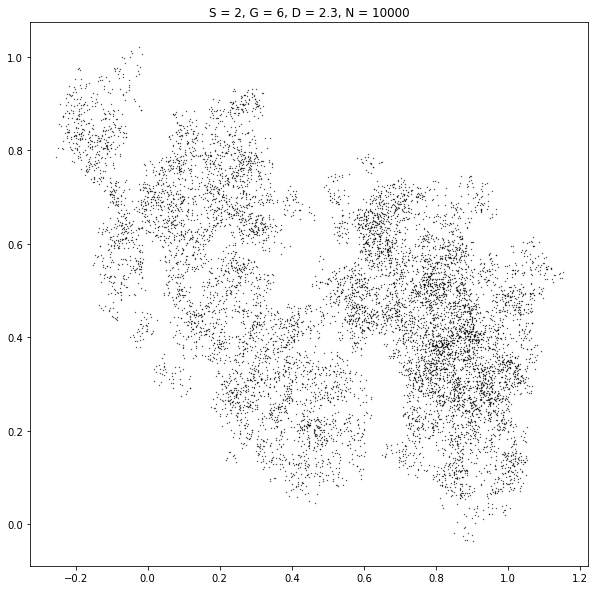

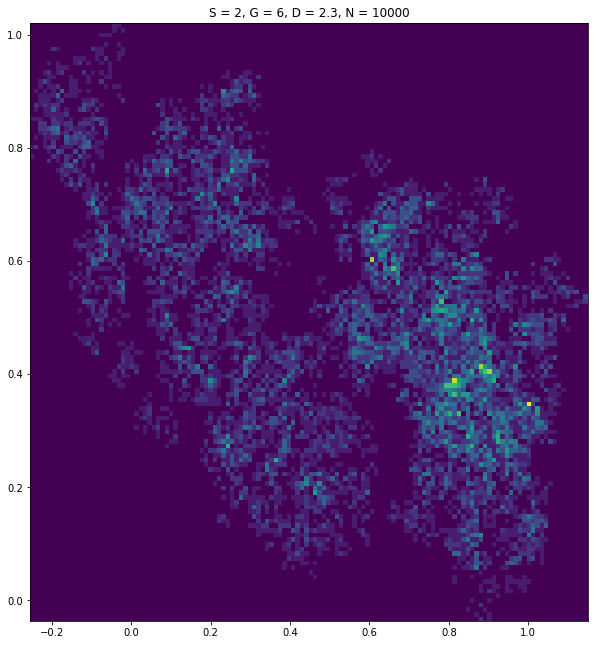

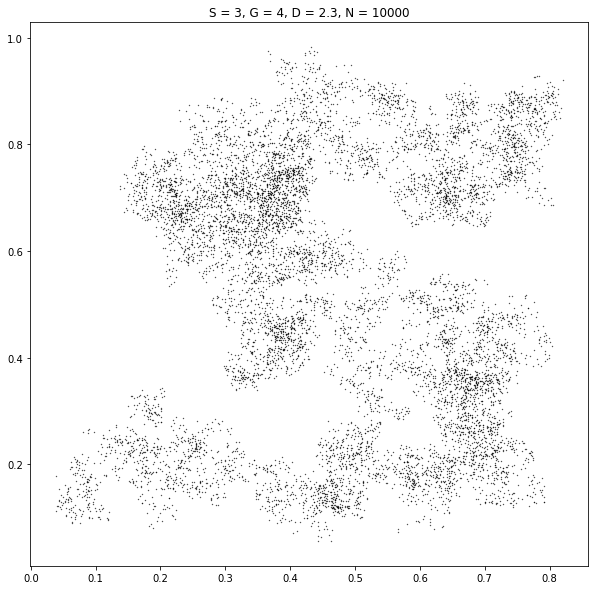

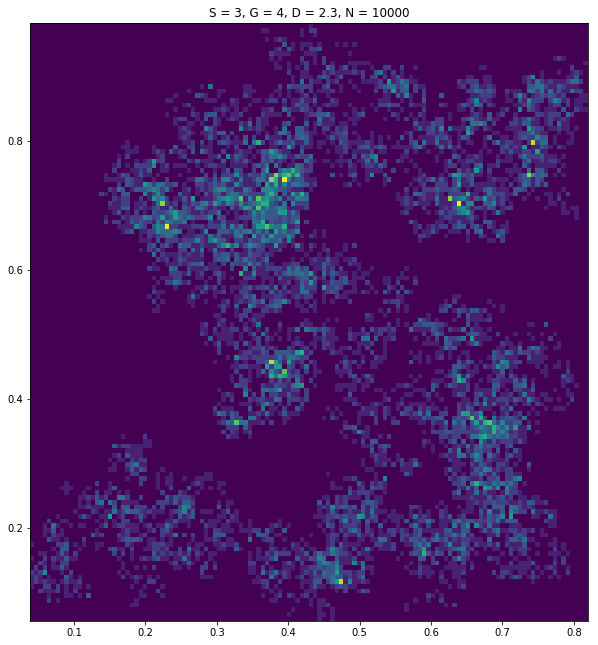

In [6]:
for i,field in enumerate(culled_star_fields_integer_S):
    plt.figure(figsize=(10,10))
    plt.title('S = {}, G = {}, D = {}, N = {}'.format(S_LIST[i],G_LIST[i],D,len(field[0])))
    plt.scatter(*field, s=.1, c='k')
    plt.show()
    
    plt.figure(figsize=(10,11))
    plt.hist2d(*field, bins=128)
    plt.title('S = {}, G = {}, D = {}, N = {}'.format(S_LIST[i],G_LIST[i],D,len(field[0])))
    plt.show()

In [7]:
separations_list_integer_S = [ordered_separations(field) for field in tqdm(culled_star_fields_integer_S)]
len(separations_list_integer_S)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:10<00:00, 15.46s/it]


20

In [8]:
s_factors = np.linspace(0.1,1.75,100)
P_s_list_integer_S = [[cum_dist_seps(culled_star_fields_integer_S[i],seps,s) for s in s_factors] for i,seps in enumerate(tqdm(separations_list_integer_S))]
len(P_s_list_integer_S)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [11:53<00:00, 36.04s/it]


20

In [9]:
integer_s_data = [[P_s_list_integer_S[i],s_factors,field] for i,field in enumerate(culled_star_fields_integer_S)]
two_point_corr_list_integer_s = [two_pt_corr(coords, P_s, s) for P_s,s,coords in integer_s_data]
len(two_point_corr_list_integer_s)

20

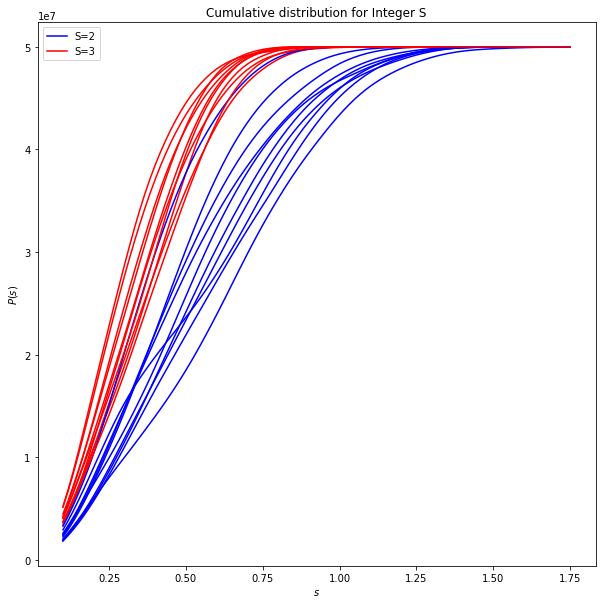

In [10]:
plt.figure(figsize=(10,10))
plt.plot([], label='S=2', color="blue")  
plt.plot([], label="S=3", color="red")  
for i,P_s in enumerate(P_s_list_integer_S):
    S=params[i][0]
    G=params[i][1]
    if S==2:
        plt.plot(s_factors,P_s, c='b')
    if S==3:
        plt.plot(s_factors,P_s, c='r')
plt.title('Cumulative distribution for Integer S')
plt.ylabel(r'$P(s)$')
plt.xlabel(r'$s$')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.show()

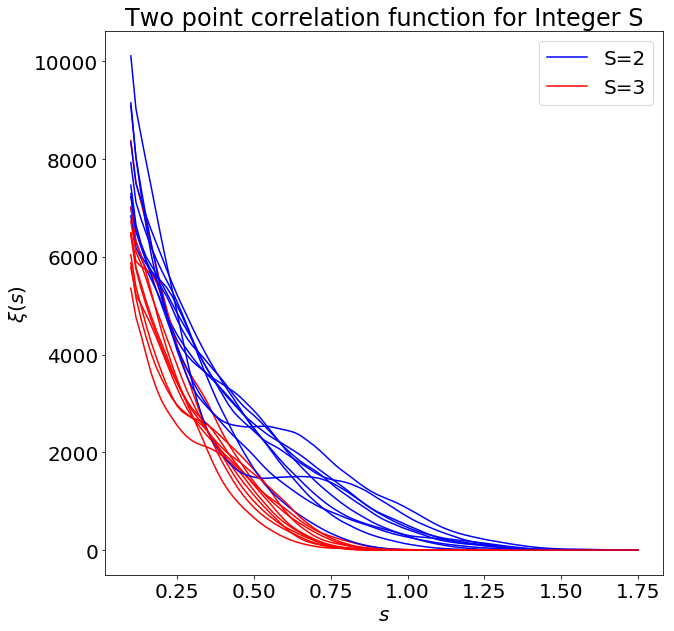

In [11]:
plt.figure(figsize=(10,10))
plt.plot([], label='S=2', color="blue")  
plt.plot([], label="S=3", color="red")  
for i,xi_s in enumerate(two_point_corr_list_integer_s):
    S=params[i][0]
    G=params[i][1]
    if S==2:
        plt.plot(s_factors,xi_s, c='b')
    if S==3:
        plt.plot(s_factors,xi_s, c='r')
plt.title('Two point correlation function for Integer S')
plt.ylabel(r'$\xi(s)$')
plt.xlabel(r'$s$')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.show()